# My First LSTM

Author: Jakob Poffley  
Date: 25/01/2024

My first attempt at fitting an LSTM to labquake data from Marone experiment p4581 (same data used by SOTA Laurenti). Heavily inspired by Pritt and Camilla's code (and ChatGPT).

In [1]:
# Imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import tqdm # progress bar


In [2]:
## Import local utils
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

from utils.dataset import SlowEarthquakeDataset


In [3]:
# Set seed so code gives the same output each time
seed = 13

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load data

In [4]:
# Load the data
EXPERIMENT = "p4581"
dataset = SlowEarthquakeDataset(EXPERIMENT)
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Reshape into dataframe
ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

# Select columns time and obs_shear_stress
ts_data = ts_data[["time", "obs_shear_stress"]]

ts_data


,time,obs_shear_stress
0,0.000,1.29911
1,0.001,1.29903
2,0.002,1.29853
3,0.003,1.29871
4,0.004,1.29854
...,...,...
200005,200.006,1.37059
200006,200.007,1.37069
200007,200.008,1.37066
200008,200.009,1.37040


Text(0.5, 1.0, 'Original Shear Stress Data, p4581')

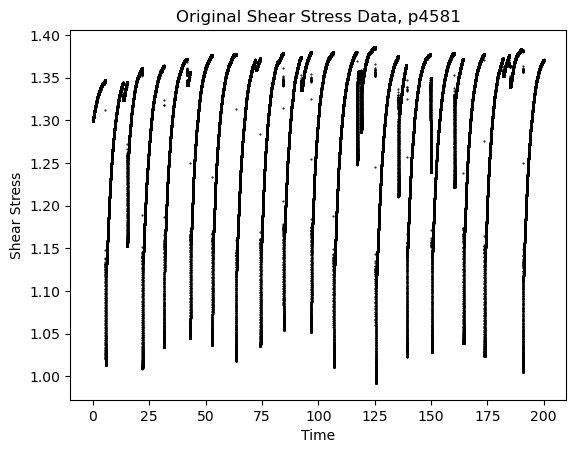

In [5]:
# Visualise the data
plt.plot("time", "obs_shear_stress", "k.", markersize =1, data=ts_data)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Original Shear Stress Data, p4581")


Text(0.5, 1.0, 'Original Shear Stress Data, p4581 (x zoomed)')

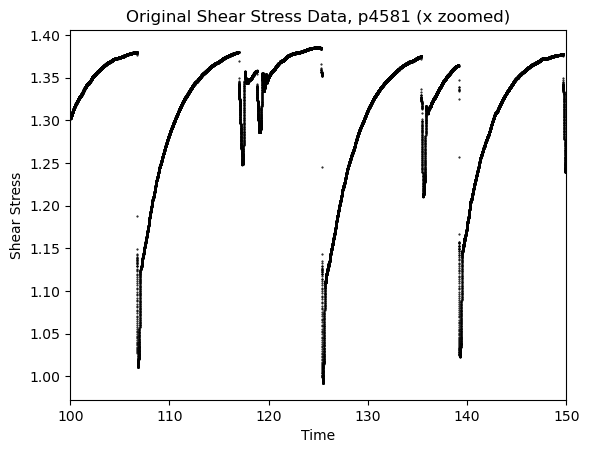

In [6]:
## Zoom into a shorter section
plt.plot("time", "obs_shear_stress", "k.", markersize =1, data=ts_data)
plt.xlim(100, 150)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Original Shear Stress Data, p4581 (x zoomed)")


## Data Downsampling

In [7]:
# Set downsampling factor
DS_FACTOR = 1000 # set very high to reduce required compute
# Downsample taking mean for each window
ts_ds_data = ts_data.rolling(window=int(DS_FACTOR), step=int(DS_FACTOR)).mean().dropna()
# Reset indices and drop rows with missing data
ts_ds_data = ts_ds_data.reset_index(drop=True)
ts_ds_data = ts_ds_data.dropna()

ts_ds_data

,time,obs_shear_stress
0,0.500503,1.306805
1,1.500508,1.320308
2,2.500513,1.330455
3,3.500518,1.337728
4,4.500523,1.342874
...,...,...
195,195.501477,1.321985
196,196.501482,1.341269
197,197.501487,1.353808
198,198.501492,1.362479


Text(0.5, 1.0, 'Downsampled Shear Stress Data, p4581')

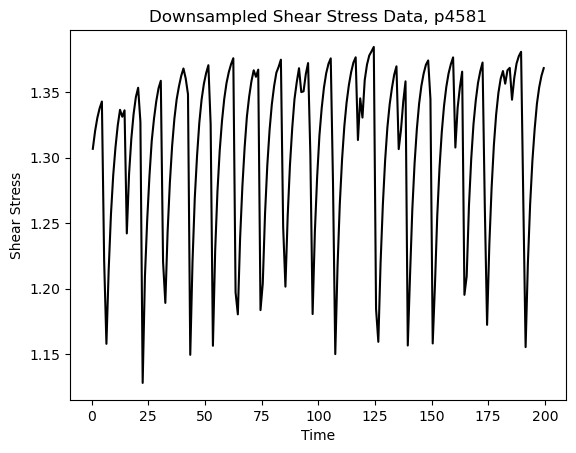

In [8]:
# Visualise downsampled data
plt.plot("time", "obs_shear_stress", "k-", markersize =1, data=ts_ds_data)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Downsampled Shear Stress Data, p4581")

## Modelling

### Create sequences of X and y's

In [9]:
# Function to create sequences based on LOOKBACK and FORECAST
def create_sequences(data, LOOKBACK, FORECAST):
    xs, ys = [], []
    for i in range(len(data) - LOOKBACK - FORECAST + 1):
        x = data[i : (i + LOOKBACK)]
        y = data[(i + LOOKBACK) : (i + LOOKBACK + FORECAST)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define LOOKBACK and FORECAST
LOOKBACK = 10
FORECAST = 1

# Generate X and y sequences
X, y = create_sequences(ts_ds_data["obs_shear_stress"].values, LOOKBACK, FORECAST)


### Feature scaling and test/train split

In [10]:
# Set scaling function
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Define split proportions
train_size = int(len(y) * 0.8)

# Perform train-test split and apply scaling
# note: the test set is transformed using the parameters fit on training data
X_train = scaler_X.fit_transform(X[:train_size])
X_test = scaler_X.transform(X[train_size:]) 
y_train = scaler_y.fit_transform(y[:train_size])
y_test = scaler_y.transform(y[train_size:])

X_train = torch.from_numpy(np.array(X_train, dtype=np.float32))
y_train = torch.from_numpy(np.array(y_train, dtype=np.float32))
X_test = torch.from_numpy(np.array(X_test, dtype=np.float32))
y_test = torch.from_numpy(np.array(y_test, dtype=np.float32))



In [11]:
# Check tensor dimensions
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")


Training data shapes: torch.Size([152, 10]), torch.Size([152, 1])
Testing data shapes: torch.Size([38, 10]), torch.Size([38, 1])


In [12]:
# Dataloader used to shuffle sequences - is this necessary?
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64
)

### Define model

In [15]:
# Define the LSTM model - I don't fully understand what is going on here yet
## some of this code is from ChatGTP. I need to check similarities/differences to Pritt's code and understand
class LSTM(nn.Module):
    def __init__(self, n_variates, hidden_size, num_layers, output_steps):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(n_variates, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_steps)
        self.fc1 = nn.Linear(num_layers * hidden_size, 128)
        self.fc2 = nn.Linear(128, output_steps)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Choose hyperparameters
n_variates = 1 
hidden_size = 50
num_layers = 1
output_steps = FORECAST
learning_rate = 0.001
num_epochs = 50 # set low for testing purposes


### Train Model

In [16]:
# Initialize the model, loss function, and optimizer
model = LSTM(n_variates, hidden_size, num_layers, output_steps)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup progress bar
pbar = tqdm.tqdm(range(num_epochs))

# Training the model - I don't understand this code yet
for epoch in pbar:
    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        train_rmse = np.sqrt(criterion(y_pred, y_train))

        y_pred = model(X_test.unsqueeze(-1))
        y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
        test_rmse = np.sqrt(criterion(y_pred, y_test))

    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [50/50], Train RMSE: 0.6492, Test RMSE: 0.6258: 100%|██████████| 50/50 [06:42<00:00,  8.05s/it]


## Model Evaluation

In [17]:
with torch.no_grad():
    y_pred = model(X_test.unsqueeze(-1))
    y_pred = torch.Tensor(scaler_y.inverse_transform(y_pred.cpu()))
    test_rmse = np.sqrt(criterion(y_pred, y_test))
    print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.6258
